NAME:- P.SARAVANAN
INDEX NUMBER:- 190568F

In [5]:
import numpy as np
from numpy.linalg import inv

In [13]:
# RANSAC FUNCTIONS

def getRandomPoints(data, n):
    #To get n random points from data set
    count = 0
    sample = []

    while count < n:
        index = np.random.randint(len(data))
        x = data[index][0]
        y = data[index][1]

        if (x, y) not in sample:
            sample.append((x, y))
            count += 1

    return sample


def getCircleParams(sample):
    #to get circle parameters from sample
    point1 = sample[0]
    point2 = sample[1]
    point3 = sample[2]

    A = np.array([[point2[0] - point1[0], point2[1] - point1[1]], [point3[0] - point2[0], point3[1] - point2[1]]]) 
    B = np.array([[point2[0]**2 - point1[0]**2 + point2[1]**2 - point1[1]**2], [point3[0]**2 - point2[0]**2 + point3[1]**2 - point2[1]**2]])		
    inv_A = inv(A)

    a, b = np.dot(inv_A, B) / 2
    a, b = a[0], b[0]
    r = np.sqrt((a - point1[0])**2 + (b - point1[1])**2)

    return (a, b, r)

def getInliersAndDistance(circle, data, threshold):
    x_data = data[:, 0]
    y_data = data[:, 1]

    a = circle[0]
    b = circle[1]
    r = circle[2]

    total_distance = 0
    inliers = []
    for i in range(len(x_data)):
        distance = np.sqrt((x_data[i] - a)**2 + (y_data[i] - b)**2)

        if abs(distance - r) <= threshold:
            inliers.append([x_data[i], y_data[i]])
            total_distance += abs(distance - r)
    
    return inliers, total_distance

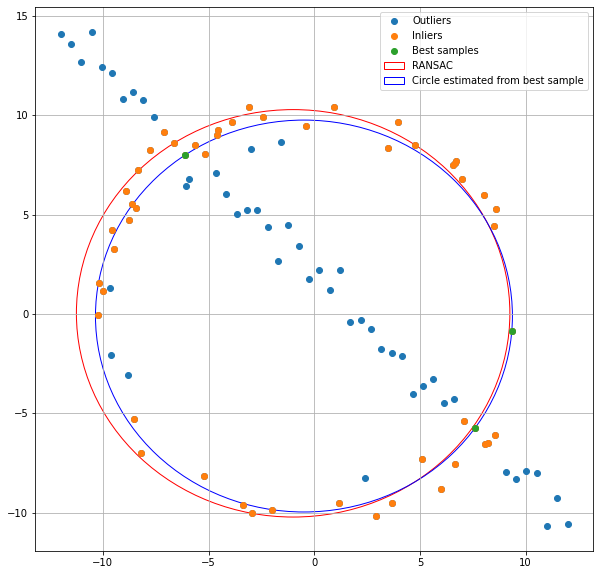

In [12]:
#Question 1)
import matplotlib.pyplot as plt
from matplotlib.patches import Circle

N = 100
nBY2 = N//2

R = 10
s = R/16
n = s*np.random.randn(nBY2)
t = np.random.uniform(0, 2*np.pi ,nBY2)


x = (R + n)*np.cos(t)
y=(R + n)*np.sin(t)

X_circle = np.hstack((x.reshape(nBY2 , 1), y.reshape(nBY2, 1)))

m, b = -1, 2
x = np.linspace(-12, 12, nBY2)
y = m*x + b + s*np.random.randn(nBY2)
X_line = np.hstack((x.reshape(nBY2, 1), y.reshape(nBY2, 1)))

X = np.vstack((X_circle, X_line))

fig, ax = plt.subplots(figsize=(10,10))
ax.plot(X[:,0], X[:, 1], 'o', label='Outliers')
ax.grid(True)

#Initialization variables
x_data = X[:, 0]
y_data = X[:, 1]
iterations = 35
inlier_threshold = R/8
inlier_count_threshold = 50
best_model = [0, 0, 999999, []]

#runnig iterations
for i in range(iterations):
    # get three points from data
    sample = getRandomPoints(X, 3)
    
    # calculate circle parameters from three points
    initial_circle = getCircleParams(sample)

    #eliminate larger circles
    if abs(R - initial_circle[2]) > 1.5*R:
        continue
    
    #calculate initial inliers 
    inliers, toal_distance = getInliersAndDistance(initial_circle, X, inlier_threshold)
    
    #if inlier count is less start from beginning
    if len(inliers) < inlier_count_threshold:
        continue

    # get three points from inliers
    inlier_sample = getRandomPoints(inliers, 3)
    
    # calculate circle parameters from three inlier points
    circle = getCircleParams(inlier_sample)

    #calculate new inliers and total absolute distance
    inliers, toal_distance = getInliersAndDistance(circle, X, inlier_threshold)
    
    #if inlier count is less start from beginning
    if len(inliers) < inlier_count_threshold:
        continue
    
    #if new circle has more inliers change best model to this new circle
    #if same amount of inliers make the best model with the circle that has less absolute distance
    if len(best_model[-1]) < len(inliers):
        best_model = [circle, initial_circle, sample, toal_distance, inliers]
    elif len(best_model[-1]) == len(inliers):
        if best_model[3] > toal_distance:
            best_model = [circle, initial_circle, sample, toal_distance, inliers]

if len(best_model[-1]) == 0:
    print("No best model found")

else:
    inliers = np.array(best_model[-1])
    ax.plot(inliers[:, 0], inliers[:, 1], 'o', label='Inliers')

    best_samples = np.array(best_model[2])
    ax.plot(best_samples[:,0], best_samples[:, 1], 'o', label='Best samples')

    a, b, r = best_model[0][0], best_model[0][1], best_model[0][2]
    circle = Circle((a, b), radius=r, color='r', fc='y', fill=False, label='RANSAC')
    ax.add_patch(circle)

    a, b, r = best_model[1][0], best_model[1][1], best_model[1][2]
    init_circle = Circle((a, b), radius=r, color='b', fc='y', fill=False, label='Circle estimated from best sample')
    ax.add_patch(init_circle)

ax.legend();



In [9]:
def click_event(event, x, y, flags, params):
    #function for getting co-ordinates by mouse click
    if event == cv.EVENT_LBUTTONDOWN:
        print(x, ' ', y)

def superimpose(im_src, im_dst, pts_src, pts_dst):
    #function to superimpose
    h, status = cv.findHomography(pts_src, pts_dst)
    im_out = cv.warpPerspective(im_src, h, (im_dst.shape[1], im_dst.shape[0]))
    return cv.add(im_out, im_dst)